In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import statsmodels.stats.api as sm
import statsmodels.stats.power as sp

plt.rc("figure", figsize=(16, 10))

In [2]:
class Money:
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return "${:.2f}".format(self.value)


class Exchange:
    def __init__(self, name, cost):
        self.name = name
        self.cost = cost

    def sample(self) -> int:
        return self.cost + np.random.normal()


class TimeOfDayEffectWrapper:
    def __init__(self, exchange: Exchange):
        self.exchange = exchange

    def sample(self, tod="afternoon"):
        bias = 2.5 if tod == "morning" else 0.0
        return self.exchange.sample()


asdaq = Exchange(name="ASDAQ", cost=12)
print(Money(asdaq.sample()))

asdaq = TimeOfDayEffectWrapper(asdaq)
print(Money(asdaq.sample("morning")))
print(Money(asdaq.sample("afternoon")))

byse = Exchange(name="BYSE", cost=10)
byse = TimeOfDayEffectWrapper(byse)
print(Money(byse.sample()))

$10.10
$12.92
$10.41
$9.54


In [3]:
print(Money(np.mean([byse.sample() for _ in range(100)])))
print(Money(np.mean([asdaq.sample() for _ in range(100)])))

$9.84
$12.04


In [4]:
def aggregate_measurements(n, exchange: Exchange):
    return np.mean([exchange.sample() for _ in range(n)])


print(np.std([aggregate_measurements(10, asdaq) for _ in range(1000)]))
print(np.std([aggregate_measurements(100, asdaq) for _ in range(1000)]))
print(np.std([aggregate_measurements(1000, asdaq) for _ in range(1000)]))

0.31283346581290916
0.10087738136912469
0.03147607502280195


In [5]:
sample_size = 10
sample_count = 1000

sample_population = np.array(
    [aggregate_measurements(sample_size, asdaq) for _ in range(sample_count)]
)
print("Mean: {:.4f}".format(sample_population.mean()))
print("Std Error: {:.4f}".format(st.sem(sample_population)))
print("Std Deviation: {:.4f}".format(sample_population.std()))

Mean: 11.9891
Std Error: 0.0096
Std Deviation: 0.3039


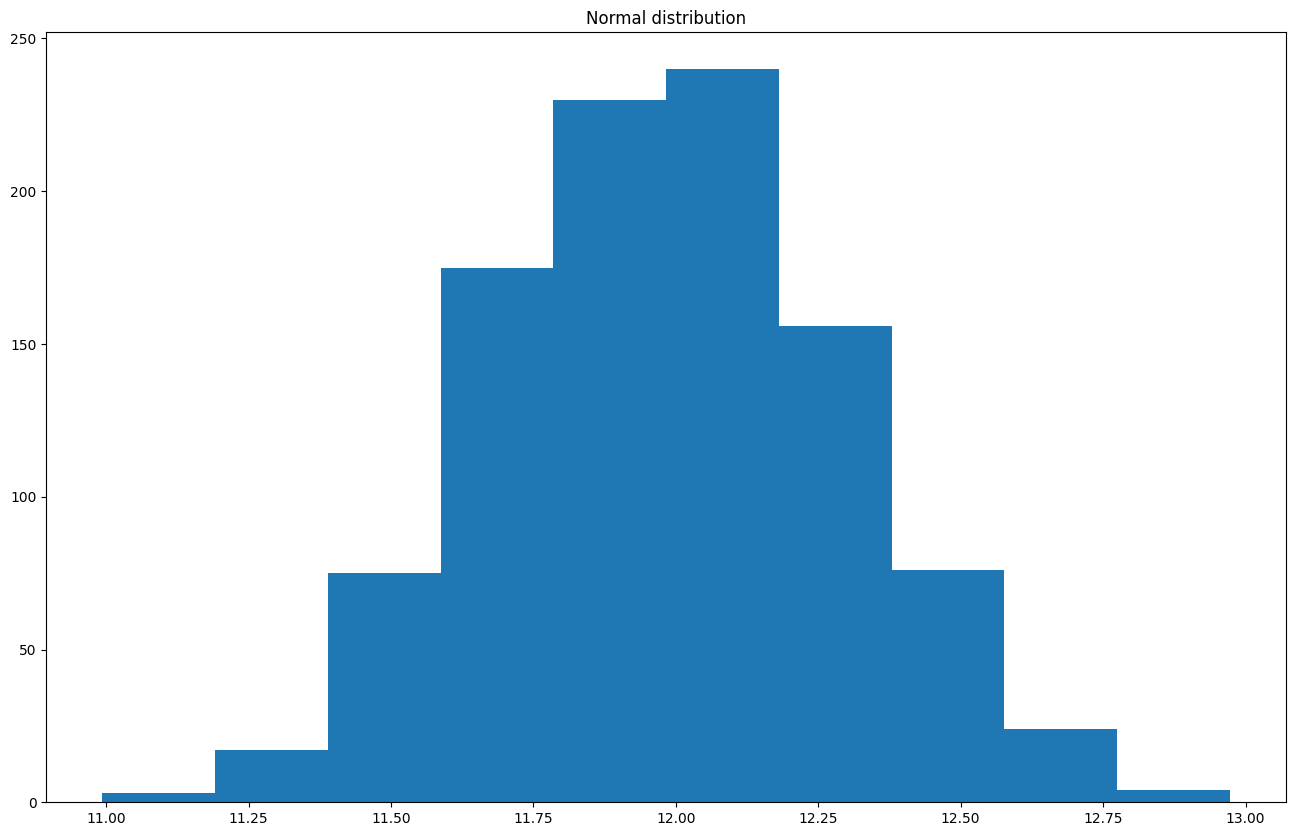

In [6]:
plt.hist(sample_population)
plt.title("Normal distribution");

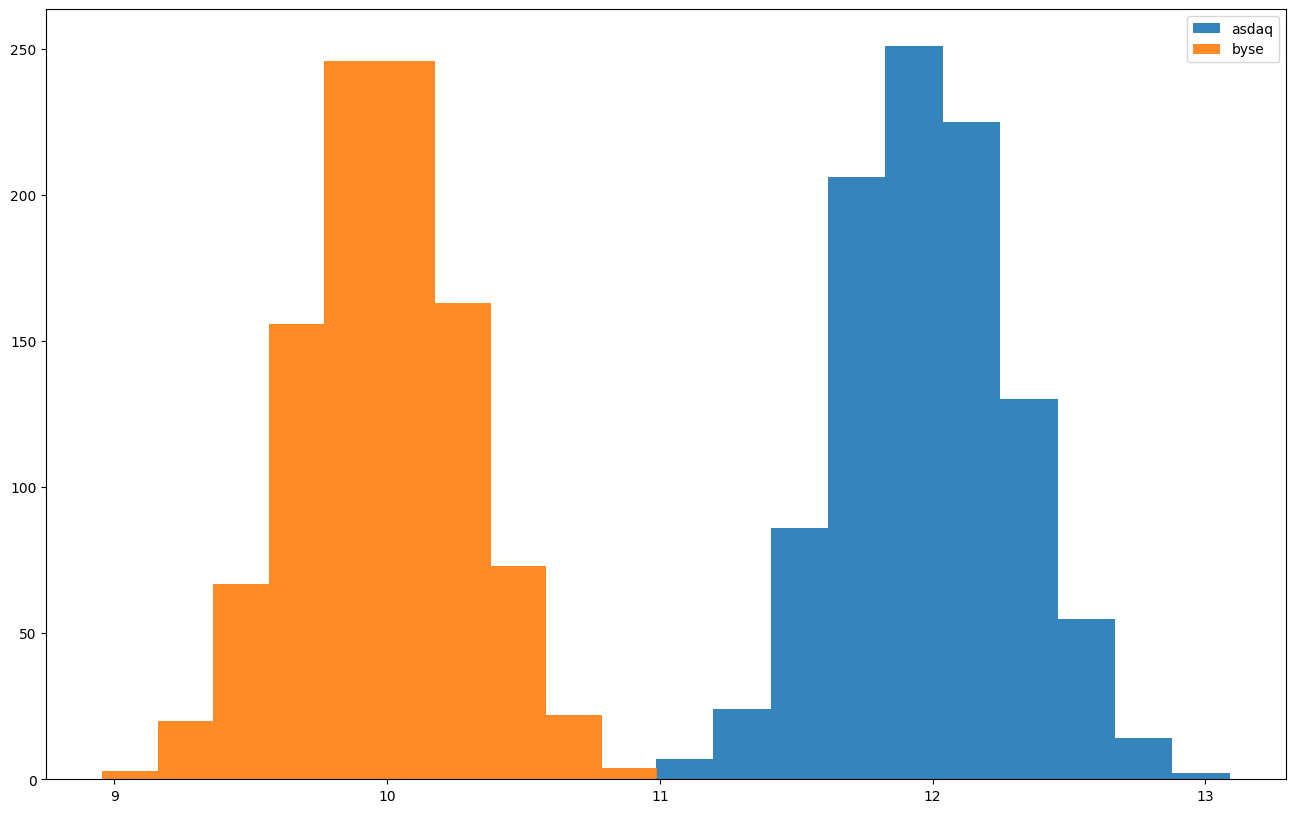

In [7]:
asdaq_sample = np.array(
    [aggregate_measurements(sample_size, asdaq) for _ in range(sample_count)]
)
byse_sample = np.array(
    [aggregate_measurements(sample_size, byse) for _ in range(sample_count)]
)
plt.hist(asdaq_sample, label="asdaq", alpha=0.9)
plt.hist(byse_sample, label="byse", alpha=0.9)
plt.legend();

The more average measurements we take, the smaller the standard deviation.

In [8]:
alpha = 0.05
beta = 0.2

diff = 1
power = 1 - beta
n1 = sp.normal_sample_size_one_tail(
    diff, power, alpha, std_null=1, std_alternative=None
)
n1 = int(np.ceil(n1))
print("at least {} individual measurements are needed".format(n1))

at least 7 individual measurements are needed


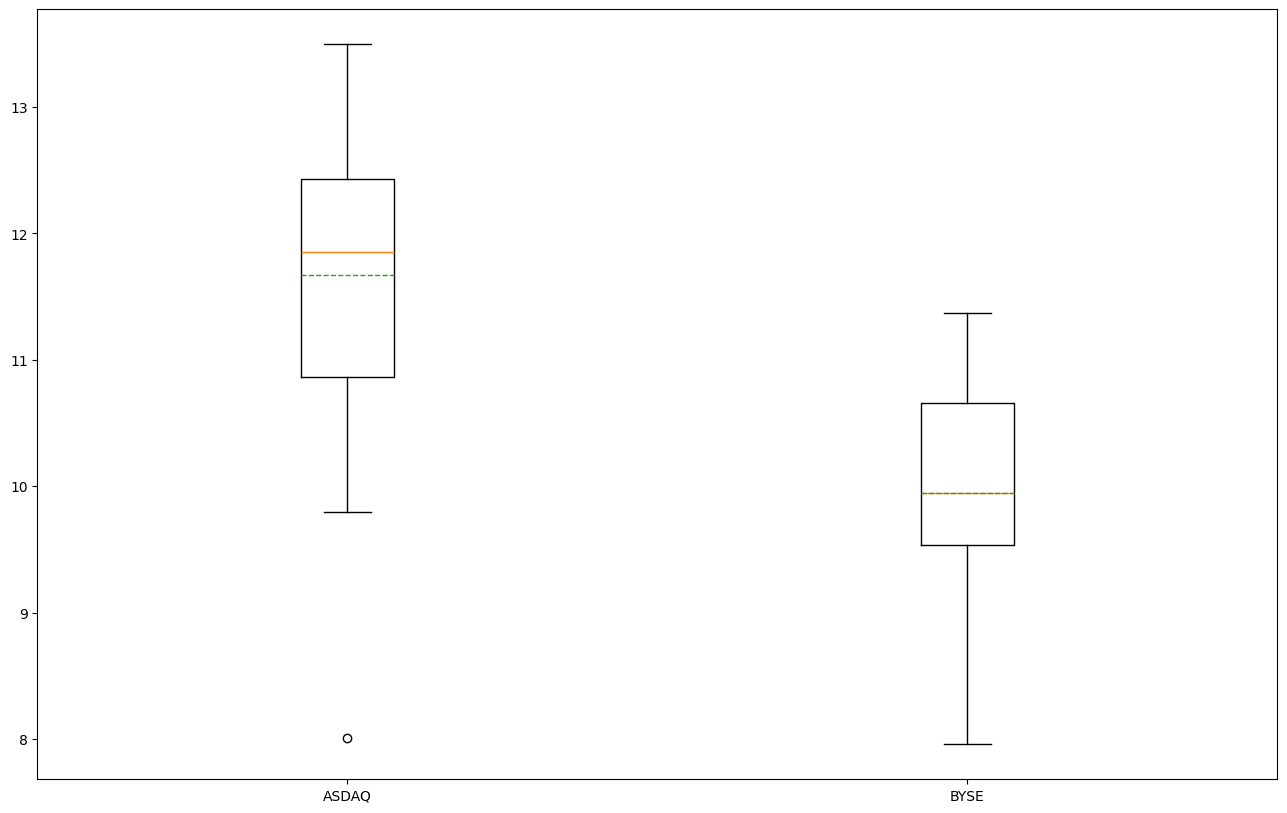

In [9]:
n = 30
asdaq_samples = []
byse_samples = []

# Randomly collecting samples for both ASDAQ and NYSE.
while len(asdaq_samples) < n or len(byse_samples) < n:
    if np.random.random() < 0.5:
        asdaq_samples.append(asdaq.sample())
    else:
        byse_samples.append(byse.sample())

plt.boxplot(
    [asdaq_samples, byse_samples],
    tick_labels=["ASDAQ", "BYSE"],
    showmeans=True,
    meanline=True,
);

In [10]:
sem = st.sem(asdaq_samples)
std = np.std(asdaq_samples)
mean = np.mean(asdaq_samples)
print("sem={:.4f} | std={:.4f} | mean={:.4f}".format(sem, std, mean))
print(len(asdaq_samples))

sem=0.2135 | std=1.1885 | mean=11.6697
32


In [11]:
sem = st.sem(byse_samples)
std = np.std(byse_samples)
mean = np.mean(byse_samples)
print("sem={:.4f} | std={:.4f} | mean={:.4f}".format(sem, std, mean))
print(len(byse_samples))

sem=0.1606 | std=0.8649 | mean=9.9430
30


In [12]:
# NOTE: The position of the X values are important.
# X1 - X2, for smaller alternative.
tstat, pvalue = sm.ztest(
    asdaq_samples,  # Control, A
    byse_samples,  # Treatment, B
    usevar="unequal",
    alternative="larger",
)
tstat, pvalue, pvalue < 0.05, st.norm.sf(tstat)

(6.463670651523492, 5.109658360505467e-11, True, 5.109658360505467e-11)

In [13]:
# correct if the population S.D. is expected to be equal for the two groups.
def cohens_d(x1, x2):
    """
    Specify the division argument on the variance with ddof=1 into the std function,
    i.e. numpy.std(c0, ddof=1).
    numpy's standard deviation default behaviour is to divide by n,
    whereas with ddof=1 it will divide by n-1.
    """
    n1 = len(x1)
    n2 = len(x2)
    s1 = np.std(x1, ddof=1)
    s2 = np.std(x2, ddof=1)
    # We can also operate under the assumption that the standard deviation of s2 = s1

    # Difference in mean
    u = np.mean(x1) - np.mean(x2)
    # Pooled standard deviation.
    s = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    return u / s


es = cohens_d(asdaq_samples, byse_samples)
es

1.6261971850246641

In [14]:
import statistics

statistics.stdev(asdaq_samples), np.std(asdaq_samples, ddof=1)

(1.2075548861950471, 1.2075548861950471)

In [15]:
# es = 1 / 1
alpha = 0.05
power = 0.8
sm.NormalIndPower().solve_power(
    effect_size=es,
    nobs1=None,
    alpha=alpha,
    power=power,
    ratio=1.0,
    alternative="larger",
)

4.675754857627041

In [16]:
sm.zt_ind_solve_power(
    effect_size=es,
    nobs1=None,
    alpha=alpha,
    power=power,
    ratio=1.0,
    alternative="larger",
)

4.675754857627041

In [17]:
sm.tt_ind_solve_power(
    effect_size=es,
    nobs1=None,
    alpha=alpha,
    power=power,
    ratio=1.0,
    alternative="larger",
)

5.500558161189811

If both sample has the same size, the pooled variance is simple the average:

In [18]:
def sample_size(x1, x2, alpha=0.05, beta=0.2, kappa=1.0):
    # Sampling ratio, κ = n_1 / n_2
    # Type I error rate, α
    # Type II error rate, β
    # Mean of group 1, μ_1 and Mean of group 2, μ_2
    u1, u2 = np.mean(x1), np.mean(x2)
    # Sample standard deviation of group 1 and Sample standard deviation of group 2
    s1, s2 = np.std(x1, ddof=1), np.std(x2, ddof=1)
    # We can also operate under the assumption that the standard deviation is the same.
    # s2 = s1

    n1 = (s1**2 + s2**2 / kappa) * (
        (st.norm.ppf(1 - alpha) + st.norm.ppf(1 - beta)) / (u1 - u2)
    ) ** 2
    return n1


sample_size(asdaq_samples, byse_samples)

4.628452969395122

In [19]:
def analyze(x1, x2):
    s1, s2 = np.std(x1, ddof=1), np.std(x2, ddof=1)
    u1, u2 = np.mean(x1), np.mean(x2)
    n1, n2 = len(x1), len(x2)

    # If the variance are equal, we can use the pooled variance.
    # pooled_var = ((n_1 - 1) * s_1**2 + (n_2 - 1) * s_2**2) / (n_1 - 1 + n_2 - 1)
    u = u1 - u2
    s = np.sqrt(s1**2 / n1 + s2**2 / n2)
    z = u / s
    p = st.norm.sf(z)
    return z, p


analyze(asdaq_samples, byse_samples)

(6.463670651523492, 5.109658360505467e-11)

In [20]:
x1 = asdaq_samples
x2 = byse_samples
sm.ttest_ind(
    x1, x2, alternative="larger", usevar="unequal", weights=(None, None), value=0
)

(6.4636706515234765, 1.2695504612656468e-08, 56.63173232071476)